In [1]:
import pandas as pd
import numpy as np

In [2]:
train_df = pd.read_csv('re-designed_train_df.csv')
info_df = pd.read_csv('re-designed_info_train_df.csv')

In [9]:
train_df.drop('Unnamed: 0', axis=1, inplace=True)
train_df.head()

,SID,lemmatized,negative - AMBIENCE#GENERAL,negative - DRINKS#PRICES,negative - DRINKS#QUALITY,negative - DRINKS#STYLE_OPTIONS,negative - FOOD#PRICES,negative - FOOD#QUALITY,negative - FOOD#STYLE_OPTIONS,negative - LOCATION#GENERAL,...,positive - DRINKS#QUALITY,positive - DRINKS#STYLE_OPTIONS,positive - FOOD#PRICES,positive - FOOD#QUALITY,positive - FOOD#STYLE_OPTIONS,positive - LOCATION#GENERAL,positive - RESTAURANT#GENERAL,positive - RESTAURANT#MISCELLANEOUS,positive - RESTAURANT#PRICES,positive - SERVICE#GENERAL
0,1000:0,manzara sahane evet servis rezalet,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1000:1,soguk su istemek soguk yok butun sulari disari...,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1000:2,yemek iyi hos lezzet iyi heyecan veri bi taraf...,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,1000:3,servis fiyat cok fazla,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1000:4,lacivert kalite dusukluguyle cok sasirtti,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split

texts = list(train_df["lemmatized"])
label_names = train_df.drop(["SID", "lemmatized"], axis=1).columns
labels = train_df[label_names].values

train_texts, test_texts, train_labels, test_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

sample_idx = 24
print(f'Sample: "{train_texts[sample_idx]}"')
print(f"Labels: {pd.Series(train_labels[sample_idx], label_names).to_dict()}")

Sample: "eski kalite olmasada iyi demek talep olunca ister istemek kalite servis vasat düşüyor et kenfi çift otopark soru fiat normal"
Labels: {'negative - AMBIENCE#GENERAL': 0, 'negative - DRINKS#PRICES': 0, 'negative - DRINKS#QUALITY': 0, 'negative - DRINKS#STYLE_OPTIONS': 0, 'negative - FOOD#PRICES': 0, 'negative - FOOD#QUALITY': 0, 'negative - FOOD#STYLE_OPTIONS': 0, 'negative - LOCATION#GENERAL': 0, 'negative - RESTAURANT#GENERAL': 0, 'negative - RESTAURANT#PRICES': 0, 'negative - SERVICE#GENERAL': 1, 'neutral - AMBIENCE#GENERAL': 0, 'neutral - DRINKS#PRICES': 0, 'neutral - DRINKS#QUALITY': 0, 'neutral - FOOD#PRICES': 0, 'neutral - FOOD#QUALITY': 0, 'neutral - FOOD#STYLE_OPTIONS': 0, 'neutral - LOCATION#GENERAL': 0, 'neutral - RESTAURANT#GENERAL': 1, 'neutral - RESTAURANT#PRICES': 1, 'neutral - SERVICE#GENERAL': 1, 'positive - AMBIENCE#GENERAL': 0, 'positive - DRINKS#QUALITY': 0, 'positive - DRINKS#STYLE_OPTIONS': 0, 'positive - FOOD#PRICES': 0, 'positive - FOOD#QUALITY': 0, 'posi

In [32]:
print("Length of train texts : ", len(train_texts))
print("Length of train texts : ", len(test_texts))
print("Length of train texts : ", len(train_labels))
print("Length of train texts : ", len(test_labels))

Length of train texts :  871
Length of train texts :  218
Length of train texts :  871
Length of train texts :  218


### A minimalistic Exploratory Data Analysis

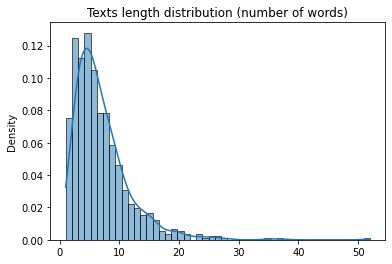

In [12]:
import seaborn as sns

text_lengths = [len(t.split()) for t in train_texts]
ax = sns.histplot(data=text_lengths, kde=True, stat="density")
ax.set_title("Texts length distribution (number of words)");

### Fine-tuning BERT

In [35]:
import transformers
print(f"Transformers package version: {transformers.__version__}")

Transformers package version: 4.15.0


In [40]:
import tensorflow as tf
from transformers import BertModel, BertTokenizer, BertConfig, BertForSequenceClassification

MODEL_NAME = 'dbmdz/bert-base-turkish-128k-cased'
MAX_LENGTH = 200  # We truncate anything after the 200-th word to speed up training

# The configuration is not needed if you don't have to customize the 
# network architecture. Here we will need it to replacee the output of the model
# with a multi-label prediction layer (i.e. sigmoid activations + binary cross-entropy
# instead of softmax + categorical cross-entropy of multi-class classification)
config = BertConfig.from_pretrained(MODEL_NAME)

tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)


train_encodings = tokenizer(train_texts, truncation=True, padding=True, 
                            max_length=MAX_LENGTH, return_tensors="tf")
test_encodings = tokenizer(test_texts, truncation=True, padding=True, 
                           max_length=MAX_LENGTH, return_tensors="tf")

# Create TensorFlow datasets to feed the model for training and evaluation
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), test_labels))

# Tokenizer output example
sample_text = "yemek iyi ama servis kötü"
tokenizer.decode(tokenizer(sample_text)["input_ids"])

'[CLS] yemek iyi ama servis kötü [SEP]'

Now that the tokenizer is available, we have to customize the output of the BERT model for our multi-label problem.

In [73]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred)
    precision = precision_score(y_true=labels, y_pred=pred)
    f1 = f1_score(y_true=labels, y_pred=pred)

    return {"accuracy": accuracy, 
            "precision": precision, 
            "recall": recall, 
            "f1": f1}

In [85]:
model = BertForSequenceClassification.from_pretrained(MODEL_NAME)

loading configuration file https://huggingface.co/dbmdz/bert-base-turkish-128k-cased/resolve/main/config.json from cache at C:\Users\burak/.cache\huggingface\transformers\38a5a8ddc3e95fba603eb96e9c7eba1cb825fcd90c61f35bcc1a44b08484984a.453a629e781b4c858049daeb69936fc02d2ee7e3314c6c65fa5f432c13470419
Model config BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.15.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 128000
}

loading weights file https://huggingface.co/dbmdz/bert-base-turkish-128k-cased/resolve/main/pytorch_model.bin from cache at C:\Users\burak/.cache\huggingface\tr

In [69]:
# Load the basic BERT model 
bert_model = BertForSequenceClassification.from_pretrained(MODEL_NAME)

inputs = bert_model.inputs[:2]
dense = bert_model.get_layer('NSP-Dense').output
outputs = keras.layers.Dense(units=2, activation='softmax')(dense)
model = keras.models.Model(inputs, outputs)

model.compile(
              Adam(5e-5),
              loss= BinaryCrossentropy(),
              metrics = [
                        multi_label_accuracy,
                        "binary_accuracy", 
                        AUC(name="average_precision", curve="PR", multi_label=True)
                        ]
            )
history = model.fit(
    train_dataset.shuffle(1000).batch(16),
    train_y,
    epochs=2, 
    batch_size=16, 
    validation_data = test_dataset.batch(16),
    shuffle=True,
)

Some weights of the model checkpoint at dbmdz/bert-base-turkish-128k-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


AttributeError: 'BertModel' object has no attribute 'inputs_embeds'

In [87]:
# some problems happened, new one is below

In [88]:
import os
import re
import string
import numpy as np
import pandas as pd
from sklearn import metrics
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, AutoTokenizer, BertModel, BertConfig, AutoModel, AdamW
import warnings
warnings.filterwarnings('ignore')

pd.set_option("display.max_columns", None)

In [89]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [90]:
# Sections of config

# Defining some key variables that will be used later on in the training
MAX_LEN = 200
TRAIN_BATCH_SIZE = 64
VALID_BATCH_SIZE = 64
EPOCHS = 10
LEARNING_RATE = 2e-5
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

loading file https://huggingface.co/dbmdz/bert-base-turkish-128k-cased/resolve/main/vocab.txt from cache at C:\Users\burak/.cache\huggingface\transformers\f52dc533c970d010b6685abf9be0d77367ef97e77595e99cb2673e97530430b2.e646aa41d1f0edf09d11ce844dabd42390c858472dee78ff02e170878c5bf42e
loading file https://huggingface.co/dbmdz/bert-base-turkish-128k-cased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/dbmdz/bert-base-turkish-128k-cased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/dbmdz/bert-base-turkish-128k-cased/resolve/main/tokenizer_config.json from cache at C:\Users\burak/.cache\huggingface\transformers\a1fa7c4d5ea5cb7b55379cd2cc9129b3f1b5af36cd1c13fa333c46f4deedfff0.c70618325b9fc2d2d041e439766d360b48a086a8841cc2896322f6b8aefc0225
loading file https://huggingface.co/dbmdz/bert-base-turkish-128k-cased/resolve/main/tokenizer.json from cache at None
loading configuration file https://huggingface.co/db

In [91]:
target_cols = [col for col in train_df.columns if col not in ['SID', 'lemmatized']]
target_cols

['negative - AMBIENCE#GENERAL',
 'negative - DRINKS#PRICES',
 'negative - DRINKS#QUALITY',
 'negative - DRINKS#STYLE_OPTIONS',
 'negative - FOOD#PRICES',
 'negative - FOOD#QUALITY',
 'negative - FOOD#STYLE_OPTIONS',
 'negative - LOCATION#GENERAL',
 'negative - RESTAURANT#GENERAL',
 'negative - RESTAURANT#PRICES',
 'negative - SERVICE#GENERAL',
 'neutral - AMBIENCE#GENERAL',
 'neutral - DRINKS#PRICES',
 'neutral - DRINKS#QUALITY',
 'neutral - FOOD#PRICES',
 'neutral - FOOD#QUALITY',
 'neutral - FOOD#STYLE_OPTIONS',
 'neutral - LOCATION#GENERAL',
 'neutral - RESTAURANT#GENERAL',
 'neutral - RESTAURANT#PRICES',
 'neutral - SERVICE#GENERAL',
 'positive - AMBIENCE#GENERAL',
 'positive - DRINKS#QUALITY',
 'positive - DRINKS#STYLE_OPTIONS',
 'positive - FOOD#PRICES',
 'positive - FOOD#QUALITY',
 'positive - FOOD#STYLE_OPTIONS',
 'positive - LOCATION#GENERAL',
 'positive - RESTAURANT#GENERAL',
 'positive - RESTAURANT#MISCELLANEOUS',
 'positive - RESTAURANT#PRICES',
 'positive - SERVICE#GENERAL

In [94]:
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler

class BERTDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.df = df
        self.max_len = max_len
        self.text = df.lemmatized
        self.tokenizer = tokenizer
        self.targets = df[target_cols].values
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]
        
        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [93]:
train_texts, test_texts, train_labels, test_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=24
)

In [99]:
train_dataset = BERTDataset(train_df, tokenizer, MAX_LEN)

In [101]:
train_loader = DataLoader(train_dataset , batch_size=TRAIN_BATCH_SIZE, 
                          num_workers=4, shuffle=True, pin_memory=True)

In [103]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model. 

class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.bert = BertForSequenceClassification.from_pretrained(MODEL_NAME)
#         self.l2 = torch.nn.Dropout(0.3)
        self.fc = torch.nn.Linear(768,5)
    
    def forward(self, ids, mask, token_type_ids):
        _, features = self.bert(ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False)
#         output_2 = self.l2(output_1)
        output = self.fc(features)
        return output

model = BERTClass()

loading configuration file https://huggingface.co/dbmdz/bert-base-turkish-128k-cased/resolve/main/config.json from cache at C:\Users\burak/.cache\huggingface\transformers\38a5a8ddc3e95fba603eb96e9c7eba1cb825fcd90c61f35bcc1a44b08484984a.453a629e781b4c858049daeb69936fc02d2ee7e3314c6c65fa5f432c13470419
Model config BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.15.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 128000
}

loading weights file https://huggingface.co/dbmdz/bert-base-turkish-128k-cased/resolve/main/pytorch_model.bin from cache at C:\Users\burak/.cache\huggingface\tr

In [104]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [105]:
optimizer = AdamW(params =  model.parameters(), lr=LEARNING_RATE, weight_decay=1e-6)

In [106]:
def train(epoch):
    model.train()
    for _,data in enumerate(train_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids']
        targets = data['targets'].to

        outputs = model(ids, mask, token_type_ids)

        loss = loss_fn(outputs, targets)
        if _%500 == 0:
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

In [ ]:
for epoch in range(EPOCHS):
    train(epoch)